# Partial Differential Equations Companion Project
## The Three Body Problem: Numerical Simulation of Lagrange Points
**Samuel Coriat**
---
**CentraleSupélec 1A**

---

This notebook is a companion to the project report. It presents and explains the full simulation code used to compute the positions of the five Lagrange points in the Circular Restricted Three-Body Problem (CR3BP), simulate the motion of a satellite near these equilibrium points, and visualize the results in both the **inertial** and **rotating** reference frames.

## Table of Contents

1. **Imports** : Required libraries
2. **System Parameters** : Earth–Moon CR3BP setup
3. **Finding Lagrange Points** : Newton-Raphson for $L_1, L_2$ and analytical formulas for $L_4, L_5$
4. **N-Body Simulation Engine** : Gravitational accelerations and RK4 integrator
5. **The `compute` Function** : Full simulation pipeline (integration + animation)
6. **Running the Simulations** : $L_1, L_2$ (unstable), $L_4, L_5$ (stable), Gascheau violation
7. **Results** : Displaying the GIF animations

## 1. Imports

We import the essential libraries for the simulation:
- **NumPy** : numerical computation (linear algebra, arrays)
- **Matplotlib** : plotting and animation
- **FuncAnimation** : to create frame-by-frame animations of the orbital trajectories
- **IPython.display** : to display GIF animations directly in the notebook

In [1]:
import numpy as np
import matplotlib
matplotlib.use('Agg')   # non-interactive backend (no display needed — we save to files)
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display

## 2. System Parameters

We work in **normalised units** where:
- The total separation between the two primaries is $R = 1$
- The gravitational constant times total mass is $G(m_1 + m_2) = 1$
- The mass ratio is $\mu = \dfrac{m_2}{m_1 + m_2}$

For the **Earth–Moon** system, we use $m_1 = 1.0$ (Earth) and $m_2 = 0.012$ (Moon), giving $\mu \approx 0.01186$.

The angular velocity of the rotating frame is:
$$\omega = \sqrt{\frac{G(m_1 + m_2)}{R^3}}$$

The positions of the primaries in the center-of-mass frame are:
- Earth: $x_1 = -\mu R$
- Moon: $x_2 = (1 - \mu) R$

The satellite has a negligible mass ($m_3 = 10^{-10}$) so it does not perturb the primaries.

In [2]:
G = 1.0
m1, m2 = 1.0, 0.012          # Earth, Moon masses
masses = [m1, m2, 1e-10]     # satellite has negligible mass
R = 1.0                       # separation between primaries

mu = m2 / (m1 + m2)          # mass ratio
omega = np.sqrt(G * (m1 + m2) / R**3)  # angular velocity

# Positions of the primaries in the center-of-mass frame
x1 = -mu * R        # Earth
x2 = (1 - mu) * R   # Moon

print("=" * 60)
print("  EARTH–MOON SYSTEM — LAGRANGE POINTS")
print("=" * 60)
print(f"  μ     = {mu:.6f}")
print(f"  ω     = {omega:.6f}")
print(f"  Earth = ({x1:.6f}, 0)")
print(f"  Moon  = ({x2:.6f}, 0)")

  EARTH–MOON SYSTEM — LAGRANGE POINTS
  μ     = 0.011858
  ω     = 1.005982
  Earth = (-0.011858, 0)
  Moon  = (0.988142, 0)


## 3. Finding the Lagrange Points

### 3.1 Collinear Points $L_1$ and $L_2$ with Newton-Raphson

The collinear Lagrange points lie on the $x$-axis ($y = 0$). Their positions satisfy the scalar equilibrium equation (derived from $\nabla U_{\text{eff}} = 0$):

$$f(x) = x - \frac{(1-\mu)(x+\mu)}{|x+\mu|^3} - \frac{\mu(x - 1 + \mu)}{|x - 1 + \mu|^3} = 0$$

This is equivalent to a **quintic polynomial** in $x$. No closed-form solution exists. We solve it numerically using **Newton-Raphson iteration**:

$$x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$$

The derivative $f'(x)$ is:

$$f'(x) = 1 - (1-\mu)\left(\frac{1}{r_1^3} - \frac{3(x+\mu)^2}{r_1^5}\right) - \mu\left(\frac{1}{r_2^3} - \frac{3(x-1+\mu)^2}{r_2^5}\right)$$

where $r_1 = |x + \mu|$ and $r_2 = |x - 1 + \mu|$.

**$x_0$ for $L_1$:** using the leading order estimate for $\mu \ll 1$:
$$x_0 = 1 - \mu - \left(\frac{\mu}{3}\right)^{1/3}$$

**$x_0$ for $L_2$:**
$$x_0 = 1 - \mu + \left(\frac{\mu}{3}\right)^{1/3}$$

In [3]:
def find_L1(mu, tol=1e-14, max_iter=200):
    """x position of L1 (between the two bodies) via Newton-Raphson."""
    # Initial guess from leading-order expansion for mu << 1
    x = 1.0 - mu - (mu / 3.0) ** (1.0 / 3.0)
    for _ in range(max_iter):
        r1 = abs(x + mu)           # distance to m1
        r2 = abs(x - 1.0 + mu)    # distance to m2
        # f(x) = equilibrium condition on the x-axis
        f  = x - (1-mu)*(x+mu)/r1**3 - mu*(x-1+mu)/r2**3
        # f'(x) = derivative for Newton-Raphson
        df = 1 - (1-mu)*(1/r1**3 - 3*(x+mu)**2/r1**5) \
               - mu*(1/r2**3 - 3*(x-1+mu)**2/r2**5)
        dx = f / df
        x -= dx
        if abs(dx) < tol:
            break
    return x

def find_L2(mu, tol=1e-14, max_iter=200):
    """x position of L2 (beyond the secondary body) via Newton-Raphson."""
    # Initial guess
    x = 1.0 - mu + (mu / 3.0) ** (1.0 / 3.0)
    for _ in range(max_iter):
        r1 = abs(x + mu)
        r2 = abs(x - 1.0 + mu)
        f  = x - (1-mu)*(x+mu)/r1**3 - mu*(x-1+mu)/r2**3
        df = 1 - (1-mu)*(1/r1**3 - 3*(x+mu)**2/r1**5) \
               - mu*(1/r2**3 - 3*(x-1+mu)**2/r2**5)
        dx = f / df
        x -= dx
        if abs(dx) < tol:
            break
    return x

# Compute L1 and L2
x_L1 = find_L1(mu)
x_L2 = find_L2(mu)

print(f"  L1 = ({x_L1:.8f}, 0)   [between Earth and Moon]")
print(f"  L2 = ({x_L2:.8f}, 0)   [beyond the Moon]")

  L1 = (0.83836606, 0)   [between Earth and Moon]
  L2 = (1.15454480, 0)   [beyond the Moon]


### 3.2 Triangular Points $L_4$ and $L_5$ : Analytical Solution

The triangular points do **not** require an iterative solver. They are found analytically by imposing that both distances to the primaries equal the separation $R$:

$$\|x - x_1\| = \|x - x_2\| = R$$

This forces the three bodies to form an **equilateral triangle**, giving:

$$x_{L_4, L_5} = \frac{1}{2} - \mu, \qquad y_{L_4, L_5} = \pm\frac{\sqrt{3}}{2}$$

In [4]:
# L4 and L5: vertices of the equilateral triangle
# In the CM frame: x = 0.5 - mu,  y = ± sqrt(3)/2
x_L4 = 0.5 - mu
y_L4 = np.sqrt(3.0) / 2.0
x_L5 = 0.5 - mu
y_L5 = -np.sqrt(3.0) / 2.0

print(f"  L4 = ({x_L4:.6f}, {y_L4:.6f})   [equilateral triangle, y > 0]")
print(f"  L5 = ({x_L5:.6f}, {y_L5:.6f})   [equilateral triangle, y < 0]")

  L4 = (0.488142, 0.866025)   [equilateral triangle, y > 0]
  L5 = (0.488142, -0.866025)   [equilateral triangle, y < 0]


## 4. N-Body Simulation Engine

### 4.1 Gravitational Accelerations

For $N$ bodies, the gravitational acceleration on body $i$ is the sum of the gravitational force created from all the other bodies:

$$\vec{a}_i = \sum_{j \neq i} \frac{G\, m_j\, (\vec{r}_j - \vec{r}_i)}{\|\vec{r}_j - \vec{r}_i\|^3}$$

A minimum distance threshold (`dist > 1e-8`) prevents numerical singularities, when bodies are at a inferior distance we detect a colision.

In [5]:
def _nbody_accel(positions, masses, G):
    """Gravitational accelerations for N bodies (numpy).
    
    For each body i, compute the vector sum of gravitational pulls
    from all other bodies 
    """
    N = len(masses)
    acc = [np.zeros(2) for _ in range(N)]
    for i in range(N):
        for j in range(N):
            if i != j:
                r_vec = positions[j] - positions[i]
                dist = np.linalg.norm(r_vec)
                if dist > 1e-8:   # avoid singularity
                    acc[i] += G * masses[j] * r_vec / dist**3
    return acc

### 4.2 Runge-Kutta 4th Order Integrator (RK4)

The equations of motion form a first order system $\dot{y} = f(t,y)$ where the state vector $y = (r_1, r_2, r_3, v_1, v_2, v_3)$ contains positions and velocities of all three bodies. Time integration is performed using the classical RK4 scheme :

$$y_{n+1} = y_n + \frac{\Delta t}{6}(k_1 + 2k_2 + 2k_3 + k_4)$$

where the intermediate slopes $k_1, \ldots, k_4$ are defined as:

$$k_1 = f(t_n,\; y_n)$$

$$k_2 = f\!\left(t_n + \frac{\Delta t}{2},\; y_n + \frac{\Delta t}{2}\,k_1\right)$$

$$k_3 = f\!\left(t_n + \frac{\Delta t}{2},\; y_n + \frac{\Delta t}{2}\,k_2\right)$$

$$k_4 = f\!\left(t_n + \Delta t,\; y_n + \Delta t\, k_3\right)$$

A fixed time step of $\Delta t = 0.001$ is used.

This gives **4th-order accuracy** ($O(\Delta t^4)$ local error), which is crucial for maintaining energy conservation over long integration times. With $\Delta t = 0.001$, we achieve relative energy errors of $|\Delta E / E| \sim 10^{-15}$ for stable configurations.

In [6]:
def _rk4_step(positions, velocities, masses, G, dt):
    """One RK4 step for the N-body system.
    
    The state is (positions, velocities) for all N bodies.
    derivs() returns (dx/dt, dv/dt) = (velocities, accelerations).
    """
    N = len(masses)

    def derivs(pos_list, vel_list):
        acc = _nbody_accel(pos_list, masses, G)
        return vel_list, acc          # dx/dt = v,  dv/dt = a

    # k1: derivatives at the current state
    dx1, dv1 = derivs(positions, velocities)

    # k2: derivatives at the midpoint using k1
    p2 = [positions[i] + 0.5 * dt * dx1[i] for i in range(N)]
    v2 = [velocities[i] + 0.5 * dt * dv1[i] for i in range(N)]
    dx2, dv2 = derivs(p2, v2)

    # k3: derivatives at the midpoint using k2
    p3 = [positions[i] + 0.5 * dt * dx2[i] for i in range(N)]
    v3 = [velocities[i] + 0.5 * dt * dv2[i] for i in range(N)]
    dx3, dv3 = derivs(p3, v3)

    # k4: derivatives at the endpoint using k3
    p4 = [positions[i] + dt * dx3[i] for i in range(N)]
    v4 = [velocities[i] + dt * dv3[i] for i in range(N)]
    dx4, dv4 = derivs(p4, v4)

    # Weighted combination: (k1 + 2*k2 + 2*k3 + k4) / 6
    new_pos = [positions[i]  + (dt / 6) * (dx1[i] + 2*dx2[i] + 2*dx3[i] + dx4[i])
               for i in range(N)]
    new_vel = [velocities[i] + (dt / 6) * (dv1[i] + 2*dv2[i] + 2*dv3[i] + dv4[i])
               for i in range(N)]
    return new_pos, new_vel

## 5. The `compute` Function : Full Simulation Pipeline

This is the main function that orchestrates the entire simulation. It performs:

1. **Center of mass correction** : Shifts all positions so that the CM is at the origin
2. **Automatic circular velocities** : Assigns $\vec{v}_i = \omega \times \vec{r}_i$ to each body so they follow circular orbits
3. **RK4 integration loop** : Advances the system step by step, with collision detection
4. **Energy diagnostic** : Computes the initial and final total energy to check conservation
5. **Rotating frame transformation** : Converts inertial-frame trajectories to the co-rotating frame by applying the rotation $\theta = -\omega t$
6. **Animation** : Creates a side-by-side video showing both the inertial and rotating frames

The **rotating frame** is key for visualizing Lagrange point stability: in this frame, the primaries are stationary, and we can see whether the satellite stays near the equilibrium point or drifts away.

In [7]:
def compute(output_name, init_pos, masses, dt=0.001, T_max=10.0):
    """N-body simulation with animation output.

    Parameters
    ----------
    output_name : str   – output file name (.mp4 or .gif)
    init_pos    : list  – [[x,y], ...] initial positions (3 bodies)
    masses      : list  – [m1, m2, m3]
    dt, T_max   : float – time step and duration
    """
    G_val = 1.0
    N = len(masses)
    collision_limit = 0.01

    # ─── Step 1: Center of mass → origin ───
    total_mass = sum(masses)
    cm = np.zeros(2)
    for i in range(N):
        cm += masses[i] * np.array(init_pos[i])
    cm /= total_mass

    pos = [np.array(init_pos[i], dtype=float) - cm for i in range(N)]

    # ─── Step 2: Automatic circular velocities ───
    # ω = √(G·M_total / a³)  where a = distance between the two primaries
    r12 = np.linalg.norm(pos[1] - pos[0])
    omega = np.sqrt(G_val * total_mass / r12**3)

    vel = []
    for i in range(N):
        x, y = pos[i]
        vel.append(np.array([-omega * y, omega * x]))   # v = ω × r (circular orbit)

    print(f"\n=== {output_name} ===")
    print(f"  CM recentered, ω = {omega:.6f}")
    for i in range(N):
        print(f"  Body {i}: pos=({pos[i][0]:+.6f}, {pos[i][1]:+.6f})  "
              f"vel=({vel[i][0]:+.6f}, {vel[i][1]:+.6f})")

    # ─── Energy diagnostic function ───
    def total_energy(p, v):
        E = 0.0
        for i in range(N):
            E += 0.5 * masses[i] * np.dot(v[i], v[i])    # kinetic
        for i in range(N):
            for j in range(i+1, N):
                r = np.linalg.norm(p[j] - p[i])
                if r > 1e-10:
                    E -= G_val * masses[i] * masses[j] / r  # potential
        return E

    E0 = total_energy(pos, vel)

    # ─── Step 3: RK4 integration loop ───
    num_steps = int(T_max / dt)
    history = [[p.copy() for p in pos]]
    times = [0.0]
    collision_time = None

    for step in range(1, num_steps + 1):
        pos, vel = _rk4_step(pos, vel, masses, G_val, dt)

        # Collision detection
        broke = False
        for i in range(N):
            for j in range(i+1, N):
                if np.linalg.norm(pos[j] - pos[i]) < collision_limit:
                    collision_time = step * dt
                    print(f"  !!! COLLISION bodies {i}-{j} at t = {collision_time:.4f}")
                    broke = True
                    break
            if broke:
                break

        history.append([p.copy() for p in pos])
        times.append(step * dt)
        if broke:
            break

    Ef = total_energy(pos, vel)
    print(f"  E initial = {E0:.8e},  E final = {Ef:.8e},  "
          f"dE/E = {abs(Ef - E0) / (abs(E0) + 1e-30):.2e}")

    # ─── Step 4: Convert to arrays for animation ───
    n_frames = len(times)
    hist_arr = [np.array([history[t][i] for t in range(n_frames)]) for i in range(N)]

    # ─── Step 5: Compute trajectories in the rotating frame ───
    # Rotate each position by -ω·t to switch to the co-rotating frame
    hist_rot = [np.zeros_like(h) for h in hist_arr]
    for k in range(n_frames):
        theta = -omega * times[k]
        c, s = np.cos(theta), np.sin(theta)
        for i in range(N):
            x, y = hist_arr[i][k]
            hist_rot[i][k, 0] = c * x - s * y
            hist_rot[i][k, 1] = s * x + c * y

    # ─── Step 6: Animation (inertial + rotating side by side) ───
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

    # Adaptive axis limits
    margin = 0.3
    all_x = np.concatenate([h[:, 0] for h in hist_arr])
    all_y = np.concatenate([h[:, 1] for h in hist_arr])
    lim = max(np.max(np.abs(all_x)), np.max(np.abs(all_y))) + margin

    for ax, title in [(ax1, "Inertial frame"), (ax2, "Rotating frame")]:
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        ax.set_aspect('equal')
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_title(title, fontsize=12, weight='bold')
        ax.set_xlabel("x"); ax.set_ylabel("y")

    colors = ['blue', 'orange', 'green']
    labels_bodies = ['Earth (m1)', 'Moon (m2)', 'Satellite (m3)']
    sizes = [10, 7, 4]

    trails_in, dots_in = [], []
    trails_rot, dots_rot = [], []
    for i in range(N):
        ln1, = ax1.plot([], [], '-', color=colors[i], linewidth=0.8, alpha=0.6)
        trails_in.append(ln1)
        d1, = ax1.plot([], [], 'o', color=colors[i], markersize=sizes[i],
                       label=labels_bodies[i], zorder=5)
        dots_in.append(d1)

        ln2, = ax2.plot([], [], '-', color=colors[i], linewidth=0.8, alpha=0.6)
        trails_rot.append(ln2)
        d2, = ax2.plot([], [], 'o', color=colors[i], markersize=sizes[i],
                       label=labels_bodies[i], zorder=5)
        dots_rot.append(d2)

    # Marker for initial satellite position in the rotating frame
    ax2.plot(hist_rot[2][0, 0], hist_rot[2][0, 1], 'k+', markersize=14,
             markeredgewidth=2, label='Initial position', zorder=4)

    ax1.legend(loc='upper right', fontsize=8)
    ax2.legend(loc='upper right', fontsize=8)
    time_text = ax1.text(0.05, 0.95, '', transform=ax1.transAxes, weight='bold')
    plt.tight_layout()

    skip = max(1, n_frames // 800)
    all_artists = trails_in + dots_in + trails_rot + dots_rot + [time_text]

    def update(frame):
        idx = frame * skip
        if idx >= n_frames:
            idx = n_frames - 1
        tail = max(0, idx - 400)
        for i in range(N):
            trails_in[i].set_data(hist_arr[i][tail:idx, 0], hist_arr[i][tail:idx, 1])
            dots_in[i].set_data([hist_arr[i][idx, 0]], [hist_arr[i][idx, 1]])
            trails_rot[i].set_data(hist_rot[i][tail:idx, 0], hist_rot[i][tail:idx, 1])
            dots_rot[i].set_data([hist_rot[i][idx, 0]], [hist_rot[i][idx, 1]])
        t_now = times[idx]
        if collision_time and idx == n_frames - 1:
            time_text.set_text(f"COLLISION t = {t_now:.2f}")
            time_text.set_color('red')
        else:
            time_text.set_text(f"t = {t_now:.2f}")
        return all_artists

    total_anim_frames = n_frames // skip
    ani = FuncAnimation(fig, update, frames=total_anim_frames, interval=20, blit=True)

    # Save as GIF (compatible without ffmpeg)
    print(f"  Saving {output_name} ...")
    if output_name.endswith('.mp4'):
        try:
            from matplotlib.animation import FFMpegWriter
            writer = FFMpegWriter(fps=30)
            ani.save(output_name, writer=writer, dpi=120)
        except Exception as e:
            fallback = output_name.replace('.mp4', '.gif')
            print(f"  ffmpeg unavailable ({e}), fallback → {fallback}")
            ani.save(fallback, writer='pillow', fps=30)
    else:
        ani.save(output_name, writer='pillow', fps=30)

    plt.close(fig)
    print(f"  → done.\n")

## 6. Running the Simulations

### 6.1 $L_1$ : Unstable Point Between Earth and Moon

$L_1$ lies on the $x$-axis between Earth and Moon at $x_{L_1} \approx 0.8384$.

The collinear points are **unconditionally unstable**: the effective potential satisfies $U_{xx} U_{yy} < 0$, guaranteeing a real positive eigenvalue and exponential divergence for any perturbation. The Lyapunov exponent is $\lambda \approx 2.93$, meaning errors amplify as $e^{\lambda t}$.

We run two simulations:
- **Equilibrium**: satellite placed exactly at $L_1$
- **Perturbed**: satellite displaced by $\delta y = 0.001$

In [ ]:
# L1: satellite exactly at the Lagrange point (equilibrium)
# T_max=6 because numerical errors cause drift after ~6s at unstable collinear points
#the code can take a long time to run (about 10minutes on my machine)
L1_pos = [[x1, 0.0], [x2, 0.0], [x_L1, 0.0]]
compute('L1_equilibrium.gif', L1_pos, masses, T_max=6.0)



=== L1_equilibrium.gif ===
  CM recentered, ω = 1.005982
  Body 0: pos=(-0.011858, +0.000000)  vel=(-0.000000, -0.011929)
  Body 1: pos=(+0.988142, +0.000000)  vel=(-0.000000, +0.994053)
  Body 2: pos=(+0.838366, +0.000000)  vel=(-0.000000, +0.843381)
  E initial = -6.00000009e-03,  E final = -6.00000009e-03,  dE/E = 1.45e-15
  Saving L1_equilibrium.gif ...


In [ ]:
# L1: satellite slightly perturbed (δy = 0.001)
L1p_pos = [[x1, 0.0], [x2, 0.0], [x_L1, 0.001]]
compute('L1_perturbed.gif', L1p_pos, masses)

### 6.2 $L_2$ : Unstable Point Beyond the Moon

$L_2$ lies beyond the Moon at $x_{L_2} \approx 1.1545$. Like $L_1$, it is **unconditionally unstable**.

This point is of great practical importance: the **James Webb Space Telescope** orbits around the $L_2$ point of the Sun–Earth system ($\sim$1.5 million km from Earth). Its instability is actually exploited — station-keeping fuel requirements are low, while active control maintains the desired orbit.

We perturb by $\delta x = 0.0005$.

In [ ]:
# L2: satellite exactly at the Lagrange point
# T_max=6 because numerical errors cause drift after ~6s at unstable collinear points
L2_pos = [[x1, 0.0], [x2, 0.0], [x_L2, 0.0]]
compute('L2_equilibrium.gif', L2_pos, masses, T_max=6.0)

# L2: satellite slightly perturbed (δx = 0.0005)
L2p_pos = [[x1, 0.0], [x2, 0.0], [x_L2 + 0.0005, 0.0]]
compute('L2_perturbed.gif', L2p_pos, masses)

### 6.3 $L_4$ : Stable Point (Equilateral Triangle, $y > 0$)

$L_4$ is located at the vertex of the equilateral triangle above the $x$-axis. Unlike $L_1$ and $L_2$, the triangular points can be **linearly stable** when the Gascheau criterion is satisfied:

$$\mu < \mu_c = \frac{1 - \sqrt{23/27}}{2} \approx 0.0385$$

For the Earth–Moon system, $\mu \approx 0.0119 < \mu_c$, so $L_4$ is **stable**. All eigenvalues of the linearised system are purely imaginary, meaning perturbations result in bounded oscillatory motion around the equilibrium.

In the Sun–Jupiter system, the **Trojan asteroids** have been trapped at $L_4$ and $L_5$ for billions of years.

We perturb by $\delta y = 0.02$.

In [ ]:
# L4: satellite exactly at the Lagrange point
L4_pos = [[x1, 0.0], [x2, 0.0], [x_L4, y_L4]]
compute('L4_equilibrium.gif', L4_pos, masses)

In [ ]:
# L4: satellite slightly perturbed (δy = 0.02)
L4p_pos = [[x1, 0.0], [x2, 0.0], [x_L4, y_L4 + 0.02]]
compute('L4_perturbed.gif', L4p_pos, masses)

### 6.4 $L_5$ : Stable Point (Equilateral Triangle, $y < 0$)

$L_5$ is the symmetric counterpart of $L_4$, located below the $x$-axis. It has the same stability properties. We perturb by $\delta y = -0.02$.

In [ ]:
# L5: satellite exactly at the Lagrange point
L5_pos = [[x1, 0.0], [x2, 0.0], [x_L5, y_L5]]
compute('L5_equilibrium.gif', L5_pos, masses)



In [ ]:
# L5: satellite slightly perturbed (δy = -0.02)
L5p_pos = [[x1, 0.0], [x2, 0.0], [x_L5, y_L5 - 0.02]]
compute('L5_perturbed.gif', L5p_pos, masses)

### 6.5 $L_5^{\text{bis}}$ : Gascheau Criterion Violated

To demonstrate the **sharpness** of the Gascheau stability boundary, we now use a modified mass ratio:

$$\mu_{\text{bis}} = 0.045 > \mu_c \approx 0.0385$$

When this criterion is violated, the characteristic equation admits eigenvalues with **positive real parts**, and the perturbation grows exponentially over time. Even a small displacement of $\delta y = 0.02$ causes the satellite to drift away from $L_5$, oscillate around the Moon, and become chaotic.

This starkly contrasts with the stable case and illustrates the Gascheau threshold as a sharp stability boundary.

In [ ]:
# Modified mass ratio that violates the Gascheau criterion
# μ_crit ≈ 0.0385, we use μ_bis = 0.045 > μ_crit
mu_bis = 0.045
m1_bis = 1.0 - mu_bis
m2_bis = mu_bis
masses_bis = [m1_bis, m2_bis, 1e-10]

x1_bis = -mu_bis * R
x2_bis = (1 - mu_bis) * R
x_L5_bis = 0.5 - mu_bis
y_L5_bis = -np.sqrt(3.0) / 2.0

print("=" * 60)
print(f"  L5_bis: μ = {mu_bis:.4f} > μ_Gascheau ≈ 0.0385 → UNSTABLE")
print(f"  Earth = ({x1_bis:.6f}, 0),  Moon = ({x2_bis:.6f}, 0)")
print(f"  L5    = ({x_L5_bis:.6f}, {y_L5_bis:.6f})")
print("=" * 60)

# Equilibrium
L5bis_pos = [[x1_bis, 0.0], [x2_bis, 0.0], [x_L5_bis, y_L5_bis]]
compute('L5_bis_equilibrium.gif', L5bis_pos, masses_bis)



In [ ]:
# Perturbed (δy = -0.02)
L5bis_p_pos = [[x1_bis, 0.0], [x2_bis, 0.0], [x_L5_bis, y_L5_bis - 0.02]]
compute('L5_bis_perturbed.gif', L5bis_p_pos, masses_bis)

## 7. Results : Displaying the Animations


### 7.1 $L_1$ : Unstable (collinear)
**Left**: Equilibrium (satellite stays still for a while, then numerical errors grow). **Right**: Perturbed satellite escapes rapidly.

L1 — Equilibrium:


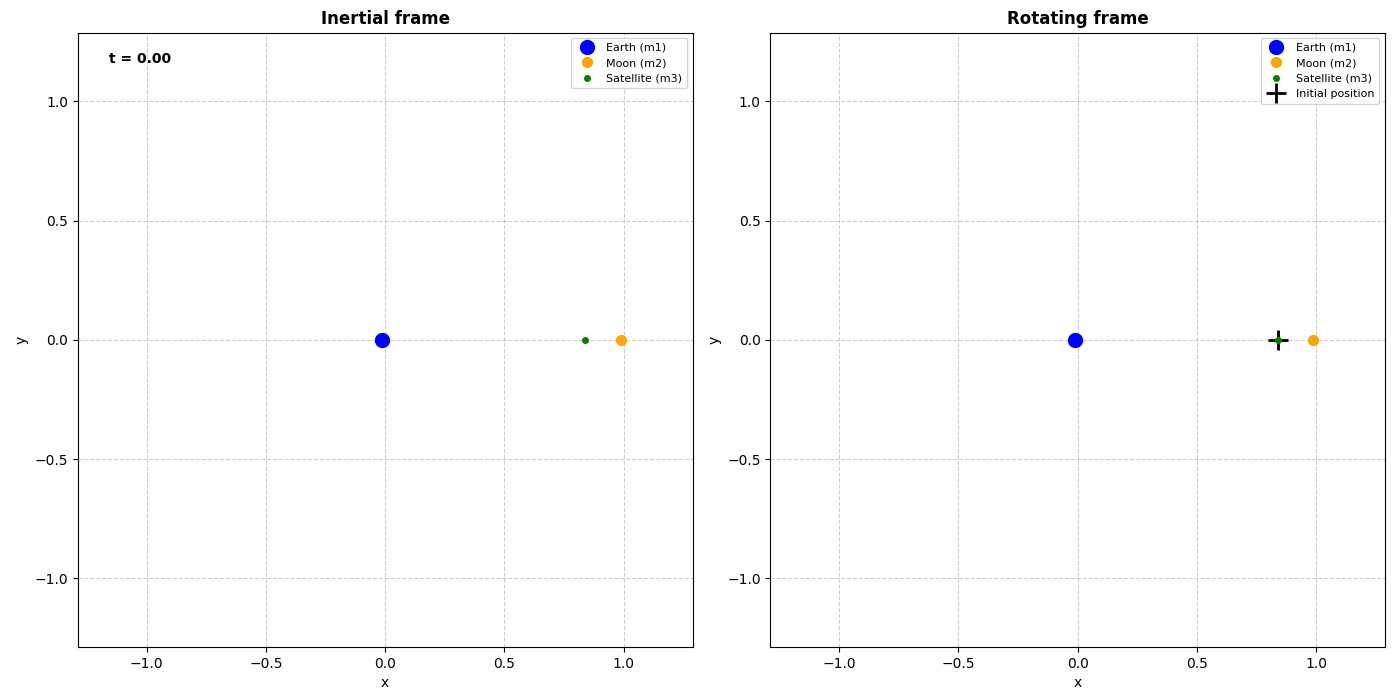


L1 — Perturbed (δy = 0.001):


In [ ]:
print("L1 — Equilibrium:")
display(Image(filename='L1_equilibrium.gif'))
print("\nL1 — Perturbed (δy = 0.001):")
display(Image(filename='L1_perturbed.gif'))

### 7.2 $L_2$ : Unstable (collinear)

L2 — Equilibrium:


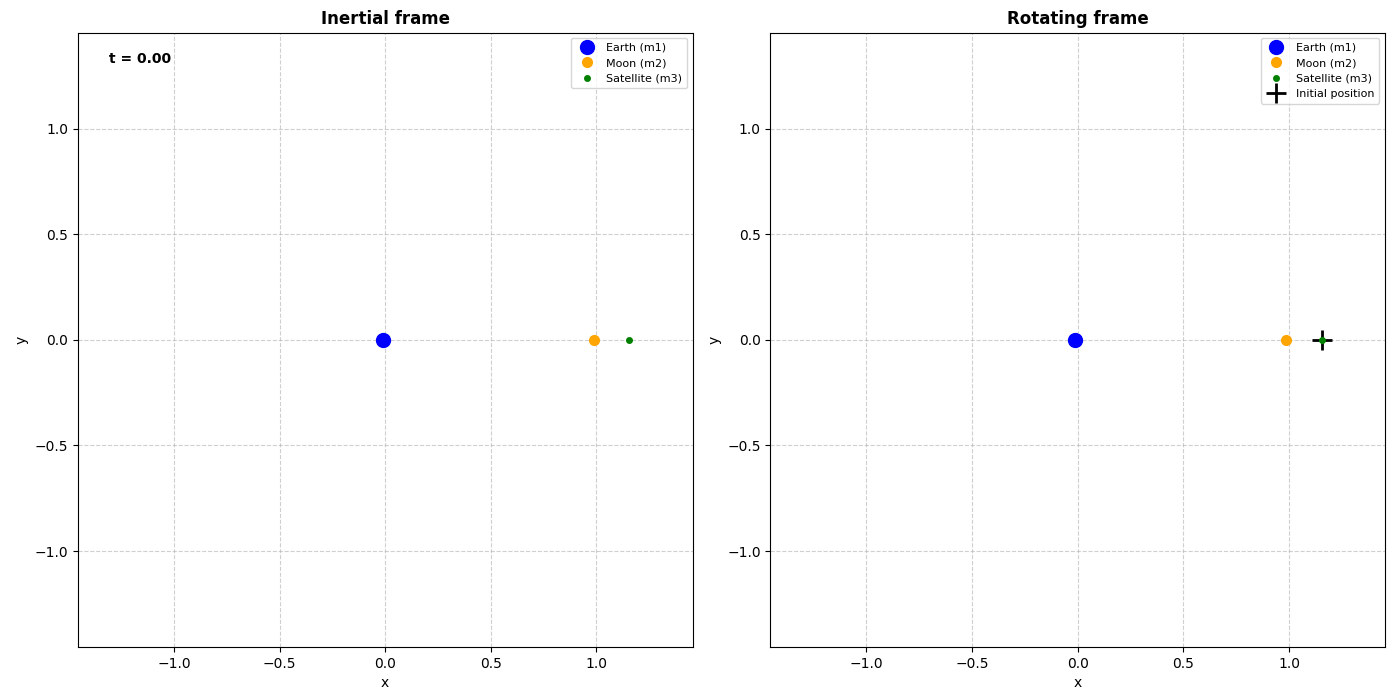


L2 — Perturbed (δx = 0.0005):


FileNotFoundError: [Errno 2] No such file or directory: 'L2_perturbed.gif'

In [ ]:
print("L2 — Equilibrium:")
display(Image(filename='L2_equilibrium.gif'))
print("\nL2 — Perturbed (δx = 0.0005):")
display(Image(filename='L2_perturbed.gif'))

### 7.3 $L_4$ : Stable (Gascheau criterion satisfied)

In [ ]:
print("L4 — Equilibrium:")
display(Image(filename='L4_equilibrium.gif'))
print("\nL4 — Perturbed (δy = 0.02):")
display(Image(filename='L4_perturbed.gif'))

### 7.4 $L_5$ : Stable (Gascheau criterion satisfied)

In [ ]:
print("L5 — Equilibrium:")
display(Image(filename='L5_equilibrium.gif'))
print("\nL5 — Perturbed (δy = -0.02):")
display(Image(filename='L5_perturbed.gif'))

### 7.5 $L_5^{\text{bis}}$ : Unstable ($\mu > \mu_c$, Gascheau violated)

Compare this with the stable $L_5$ above: same perturbation magnitude, but here the trajectory diverges chaotically because $\mu = 0.045 > \mu_c \approx 0.0385$.

In [ ]:
print("L5_bis — Equilibrium (μ = 0.045):")
display(Image(filename='L5_bis_equilibrium.gif'))
print("\nL5_bis — Perturbed (δy = -0.02, μ = 0.045 → UNSTABLE):")
display(Image(filename='L5_bis_perturbed.gif'))

## 8. Summary

| Lagrange Point | Position | Stability | Perturbation | Behaviour |
|:---:|:---:|:---:|:---:|:---:|
| $L_1$ | $(0.8384, 0)$ | **Unstable** | $\delta y = 0.001$ | Exponential escape |
| $L_2$ | $(1.1545, 0)$ | **Unstable** | $\delta x = 0.0005$ | Exponential escape |
| $L_4$ | $(0.4881, 0.8660)$ | **Stable** ($\mu < \mu_c$) | $\delta y = 0.02$ | Bounded oscillation |
| $L_5$ | $(0.4881, -0.8660)$ | **Stable** ($\mu < \mu_c$) | $\delta y = -0.02$ | Bounded oscillation |
| $L_5^{\text{bis}}$ | $(0.455, -0.866)$ | **Unstable** ($\mu > \mu_c$) | $\delta y = -0.02$ | Chaotic divergence |

### Key results:
- **Collinear points** ($L_1, L_2, L_3$): unconditionally unstable — $U_{xx}U_{yy} < 0$ guarantees at least one real positive eigenvalue.
- **Triangular points** ($L_4, L_5$): conditionally stable under the **Gascheau criterion** $\mu < \mu_c \approx 0.0385$.
- The RK4 integrator with $\Delta t = 0.001$ achieves relative energy conservation $|\Delta E / E| \sim 10^{-15}$ for stable configurations.
- The **Lyapunov exponent** $\lambda \approx 2.93$ at the collinear points quantifies the exponential divergence rate.